In [1]:
import h5py

mat_file_path = 'Houston18.mat'

# Load the .mat file
with h5py.File(mat_file_path, 'r') as file:
    # Print the keys in the .mat file to see what variables are available
    print("Keys in the .mat file:", list(file.keys()))
    
    # Accessing a specific variable
    array_data = file['ori_data'][:]
    print(array_data.shape)


# Access a specific variable (replace 'your_variable' with the actual variable name)
# array_data = mat_contents['pavia']

# # # Display the array
print(array_data.shape)


Keys in the .mat file: ['ori_data']
(48, 954, 210)
(48, 954, 210)


In [2]:
# print(array_data[1000][700][10].dtype)

In [3]:
import h5py

mat_file_path = 'Houston18_7gt.mat'

# Load the .mat file
with h5py.File(mat_file_path, 'r') as file:
    # Print the keys in the .mat file to see what variables are available
    print("Keys in the .mat file:", list(file.keys()))
    
    # Accessing a specific variable
    y_data = file['map'][:]
    print(y_data.shape)

# Print the keys in the .mat file to see what variables are available
# print("Keys in the .mat file:", mat_contents.keys())

# Access a specific variable (replace 'your_variable' with the actual variable name)
# y_data = mat_contents['pavia_gt']

# Display the array
print(y_data.shape)


Keys in the .mat file: ['map']
(954, 210)
(954, 210)


In [4]:
from glob import glob
import numpy as np
from scipy.io import loadmat
import rasterio as rio
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

# np.seterr(divide='ignore', invalid='ignore')
     

# S_sentinel_bands = glob("sundarbans_data/*B?*.tiff")
# S_sentinel_bands.sort()

# l = []
# for i in S_sentinel_bands:
#   with rio.open(i, 'r') as f:
#     l.append(f.read(1))

# # Data
# arr_st = np.stack(l)
# print(arr_st.shape)

# # Ground Truth
# y_data = loadmat('Sundarbands_gt.mat')['gt']

Initial shape: (954, 210, 48)
Transposed shape: (48, 954, 210)


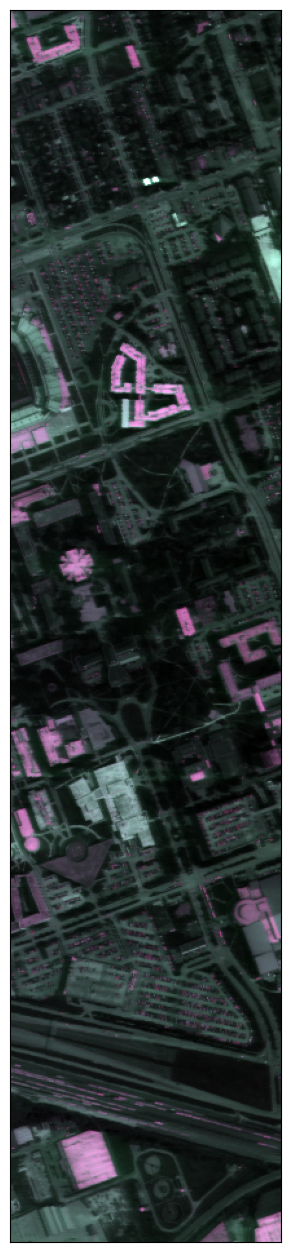

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import earthpy.plot as ep

# Assuming array_data is a NumPy array with shape (1096, 715, 102)
print("Initial shape:", array_data.shape)  # Output should be (1096, 715, 102)

# Transpose the array to bring the last dimension to the first position
array_data = np.transpose(array_data, (2, 0, 1))  # New shape will be (102, 1096, 715)
print("Transposed shape:", array_data.shape)  # Output should be (102, 1096, 715)

# Plot the RGB composite image
ep.plot_rgb(
    array_data,
    rgb=(3, 1, 2),  # Adjust based on your RGB channels' order
    stretch=True,
    str_clip=0.02,
    figsize=(12, 16),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()


In [8]:
import numpy as np

# Assuming y_data is your ground truth data array
unique_labels = np.unique(y_data)

print("Unique labels in y_data:", unique_labels)
print("Number of unique labels:", len(unique_labels))


Unique labels in y_data: [0. 1. 2. 3. 4. 5. 6. 7.]
Number of unique labels: 8


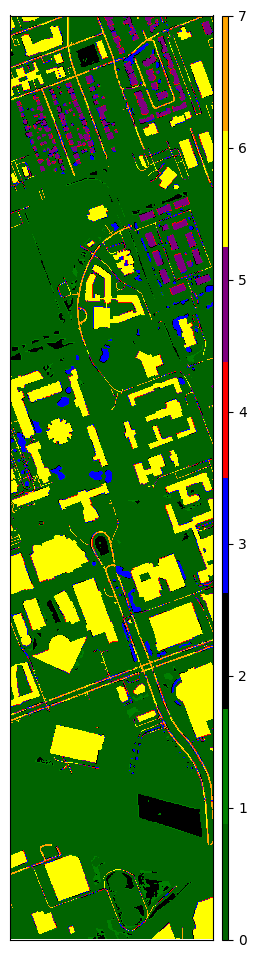

In [9]:
# Visualize Groundtruth

ep.plot_bands(y_data, 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 'blue', 'red', 'purple', 
    'yellow', 'orange']))
plt.show()

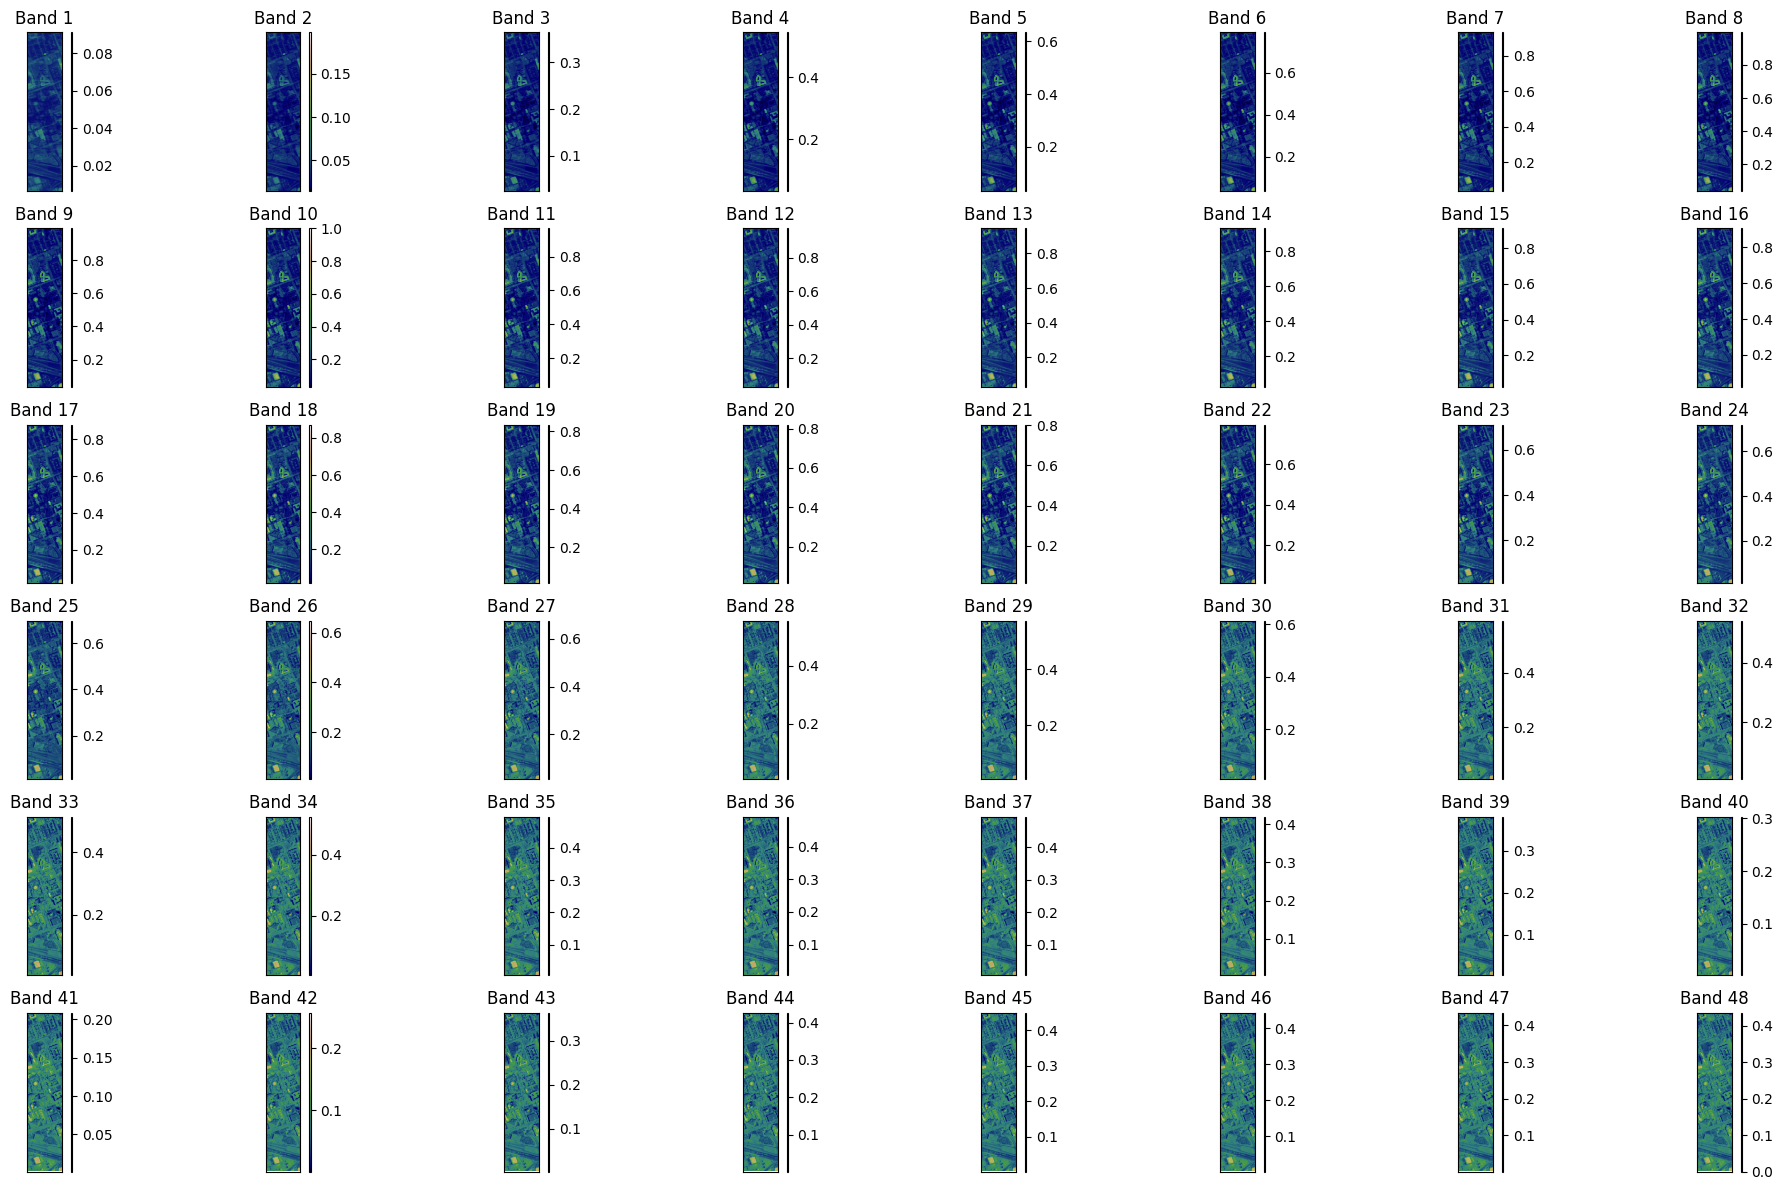

In [9]:
ep.plot_bands(array_data, 
              cmap = 'gist_earth', 
              figsize = (20, 12), 
              cols = 8, 
              cbar = True)
plt.show()

In [10]:
import pca
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX
def createImageCubes(X, y, windowSize=5, removeZeroLabels = False):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
def splitTrainTestSet(X, y, testRatio, randomState=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test
## GLOBAL VARIABLES
dataset = 'SB'
test_size = 0.25
windowSize = 15
MODEL_NAME = 'Sundarbans'
# path = '/content/drive/MyDrive/Sundarbans/'

X_data = np.moveaxis(array_data, 0, -1).astype(np.float32)
# y_data
# X_data_train=X_data[200:500,200:500,:]
# y_data_train=y_data[200:500,200:500]
# for i in range
# Apply PCA

# for train
K = 10
print(f'data_train before pca:{X_data.shape}')
X_train,pca = applyPCA(X_data,numComponents=K)

print(f'Data_train After PCA: {X_train.shape} and {X_train.dtype}')

# Create 3D Patches
X, y = createImageCubes(X_train, y_data, windowSize=windowSize,)
print(f'Patch size: {X.shape}')

# Split train and test
# X_data_test=X_data[0:150,0:150,:]
# y_data_test=y_data[0:150,0:150]
# # for i in range
# Apply PCA

# for train
# K = 10
# print(f'data_test before pca:{X_data.shape}')
# X_test,pca = applyPCA(X_data_test,numComponents=K)

# print(f'Data_test After PCA: {X_test.shape} and {X_test.dtype}')

# Create 3D Patches
# X_test, y_test = createImageCubes(X_test, y_data_test, windowSize=windowSize,)
# print(f'Patch size: {X.shape}')

# for testing 





X_train, X_test, y_train, y_test = splitTrainTestSet(X, y, testRatio = test_size)

# X_train=X_train[0:198976]
# y_train=y_train[0:198976]
# X_test=X_test[0:85280]
# y_test=y_test[0:85288]
# X_train=X_train[0:200000]
# y_train=y_train[0:200000]/
# X_test=X_test[0:60000]
# y_test=y_test[0:60000]
X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)

# One Hot Encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'Train: {X_train.shape}\nTest: {X_test.shape}\nTrain Labels: {y_train.shape}\nTest Labels: {y_test.shape}')


data_train before pca:(954, 210, 48)
Data_train After PCA: (954, 210, 10) and float32
Patch size: (200340, 15, 15, 10)
Train: (150255, 15, 15, 10, 1)
Test: (50085, 15, 15, 10, 1)
Train Labels: (150255, 8)
Test Labels: (50085, 8)


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

def calculate_padding(k1, s1, k2 , s2, k3, s3):
    return ((k1 - s1)//2 , (k2-s2)//2 , (k3-s3)//2)

class ResNet3D(nn.Module):
    def __init__(self, output_units):
        super(ResNet3D, self).__init__()

        # First layer
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=calculate_padding(3,1,3,2,3,2))
        self.conv11 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=calculate_padding(1,1,3,1,3,1))
        self.norm1 = nn.BatchNorm3d(32)
        
        # Second layer
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=calculate_padding(1,1,3,1,3,1))
        self.conv22 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=calculate_padding(1,1,3,1,3,1))
        self.norm2 = nn.BatchNorm3d(64)
        
        # Third layer
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 2, 2), stride=(1, 2, 2), padding=calculate_padding(3,1,2,1,2,1))
        self.conv33 = nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=calculate_padding(2,1,3,1,3,1))
        self.norm3 = nn.BatchNorm3d(128)
        
        # Fourth layer
        self.conv4 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=(2, 1, 1), stride=(1, 1, 1), padding=calculate_padding(2,1,2,1,2,1))
        # self.conv44 = nn.Conv3d(in_channels=64, out_channels=16, kernel_size=(2, 2, 2), stride=(1, 1, 1), padding=calculate_padding(2, 1,2,1,2,1))
        # self.norm4 = nn.BatchNorm3d(16)
        
        # Fifth layer
        self.conv5 = nn.Conv3d(in_channels=64, out_channels=16, kernel_size=(3, 2, 2), stride=(1, 1, 1), padding=calculate_padding(1,1,1,1,1,1))
        
        # Flatten and dense layer
        self.flatten = nn.Flatten()
        self.final_cnn_dense = nn.Linear(16 *7*2*2, output_units)  # Adjusted based on input dimension reduction

    def forward(self, x):
        # x = x.permute(0, 4, 1, 2, 3)
        # print(x.shape)
        
        x = self.conv1(x)
        residual1=x
        # print(x.shape)
        x = self.conv11(x)
        # print(x.shape)
        x = self.norm1(x)
        # print(x.shape)
        
        # residual1 = self.conv1(x)
        x = x + residual1
        # x=drop_block3d(x)
        # print(x.shape)
        x = F.relu(x)
        # print("second strat")
        x = self.conv2(x)
        # print("3rd start")
        # print(x.shape)
        residual2=x
        # x=drop_block3d(x)
        x = self.conv22(x)
        # print(x.shape)
        x = self.norm2(x)
        # print(x.shape)
        
        # residual2 = self.conv2(x)
        x = x + residual2
        # print("after add",x.shape)
        x = F.relu(x)
        
        # print("3rd start")
        x = self.conv3(x)
        # print(x.shape)
        residual3=x
        x = self.conv33(x)
        # print(x.shape)
        x = self.norm3(x)
        # print(x.shape)
        # x = F.relu(x)
        # residual3 = self.conv3(x)
        x = x + residual3
        x = F.relu(x)

        # print(x.shape)
        x = self.conv4(x)
        # residual4=x
        # x = self.conv44(x)
        # x = self.norm4(x)
        # x = F.relu(x)
        # residual4 = self.conv4(x)
        # x = x + residual4
        x = F.relu(x)
        # print(x.shape)

        x = self.conv5(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        x = self.final_cnn_dense(x)
        return x

# Example usage
output_units = 8 # Example output units, adjust based on y_train.shape[1]

# Initialize model
model = ResNet3D(output_units=output_units)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_train_tensor = X_train_tensor.permute(0, 4, 3, 1, 2)
# X_train_tensor = X_train_tensor.permute(0, 2, 1, 3, 4)
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)


ResNet3D(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 0, 0))
  (conv11): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (norm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (conv22): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (norm2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(64, 128, kernel_size=(3, 2, 2), stride=(1, 2, 2), padding=(1, 0, 0))
  (conv33): Conv3d(128, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (norm3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(128, 64, kernel_size=(2, 1, 1), stride=(1, 1, 1))
  (conv5): Conv3d(64, 16, kernel_size=(3, 2, 2), stride=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (final_cnn_d

In [22]:
import torch
from dropblock import DropBlock3D

# (bsize, n_feats, depth, height, width)
# x = torch.rand(100, 10, 16, 16, 16)

drop_block3d = DropBlock3D(block_size=2, drop_prob=0.1)


In [23]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device).float()
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        # if(i==2):
        #     break;
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        # if i == 6217:
        #     print("ab na ho payega bhai")
        #     break

# Save the trained model
# torch.save(model.state_dict(), '3d_cnn_model.pth')


Epoch [1/5], Step [100/4696], Loss: 0.6406
Epoch [1/5], Step [200/4696], Loss: 0.2724
Epoch [1/5], Step [300/4696], Loss: 0.2749
Epoch [1/5], Step [400/4696], Loss: 0.3216
Epoch [1/5], Step [500/4696], Loss: 0.4607
Epoch [1/5], Step [600/4696], Loss: 0.5040
Epoch [1/5], Step [700/4696], Loss: 0.2592
Epoch [1/5], Step [800/4696], Loss: 0.1483
Epoch [1/5], Step [900/4696], Loss: 0.4469
Epoch [1/5], Step [1000/4696], Loss: 0.2992
Epoch [1/5], Step [1100/4696], Loss: 0.4732
Epoch [1/5], Step [1200/4696], Loss: 0.6106
Epoch [1/5], Step [1300/4696], Loss: 0.4422
Epoch [1/5], Step [1400/4696], Loss: 0.2807
Epoch [1/5], Step [1500/4696], Loss: 0.4513
Epoch [1/5], Step [1600/4696], Loss: 0.2094
Epoch [1/5], Step [1700/4696], Loss: 0.2514
Epoch [1/5], Step [1800/4696], Loss: 0.2217
Epoch [1/5], Step [1900/4696], Loss: 0.5809
Epoch [1/5], Step [2000/4696], Loss: 0.2044
Epoch [1/5], Step [2100/4696], Loss: 0.0925
Epoch [1/5], Step [2200/4696], Loss: 0.4308
Epoch [1/5], Step [2300/4696], Loss: 0.56

In [24]:
# X_test=X_test[0:85288]
# y_test=y_test[0:85288]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(train_dataset, batch_size=32)


In [25]:
# Put the model in evaluation mode
model.eval()

# Initialize variables to track accuracy and total number of samples
total_correct = 0
total_samples = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for j, (inputs, labels) in enumerate(test_loader):  # Assuming you have a DataLoader named test_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        labels = torch.argmax(labels, 1)  # Convert one-hot encoded labels to class indices
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        if (j + 1) % 100 == 0:
            print(j+1)

accuracy = (total_correct / total_samples) * 100
print(f'Accuracy of the model: {accuracy:.2f}%')


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
Accuracy of the model: 95.76%
